In [1]:
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# Example data
# Replace this with your actual data
time_train = np.array([5, 6, 7, 8, 9])
event_train = np.array([1, 0, 1, 0, 1])
X_train = np.array([[50, 1], [60, 1], [70, 0], [80, 0], [90, 1]])

# Prepare the survival data
y_train = Surv.from_arrays(event=event_train, time=time_train)

# Fit the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100)
rsf.fit(X_train, y_train)

# Predict survival probabilities at different time points
time_points = np.array([4, 5, 6, 7, 8])
pred_surv = rsf.predict_survival_function(X_train, return_array=True)

# Print survival probabilities
for i, t in enumerate(time_points):
    print(f"Survival probabilities at time {t}: {pred_surv[:, i]}")

Survival probabilities at time 4: [0.794 0.794 0.794 0.794 0.794]
Survival probabilities at time 5: [0.794 0.794 0.794 0.794 0.794]
Survival probabilities at time 6: [0.58866667 0.58866667 0.58866667 0.58866667 0.58866667]
Survival probabilities at time 7: [0.58866667 0.58866667 0.58866667 0.58866667 0.58866667]
Survival probabilities at time 8: [0.18383333 0.18383333 0.18383333 0.18383333 0.18383333]


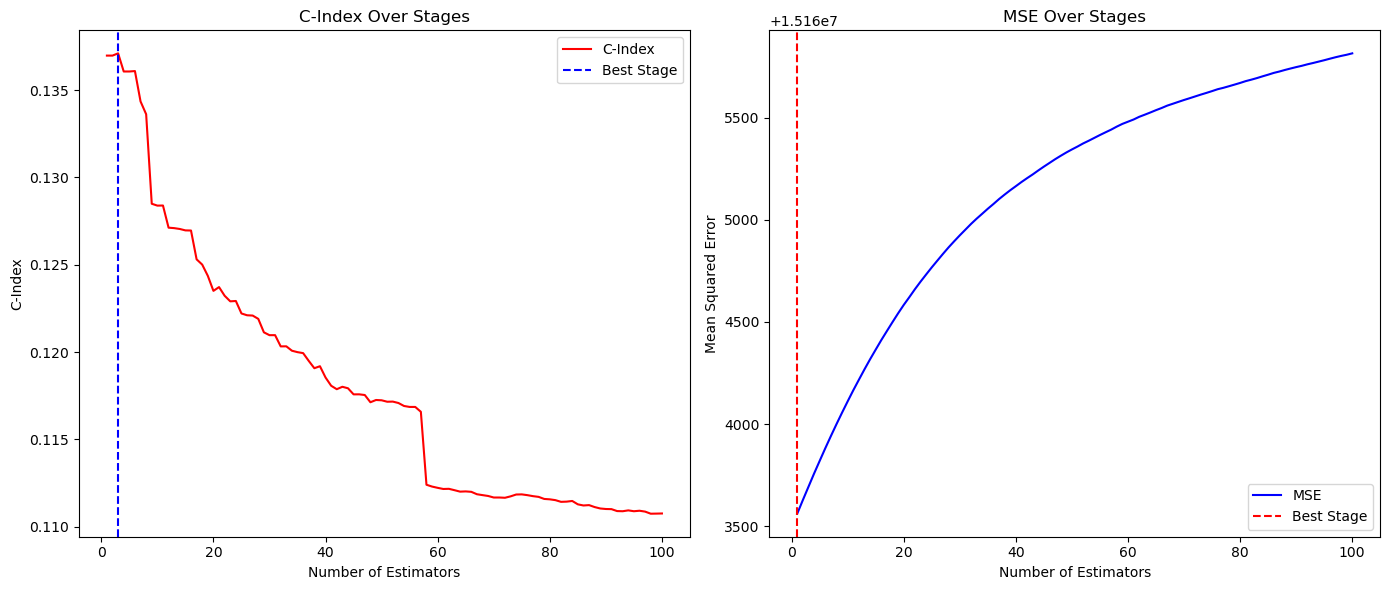

Best Stage for C-Index: 3, Best C-Index: 0.1371
Best Stage for MSE: 1, Lowest MSE: 15163560.8324


In [2]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
from sksurv.datasets import load_flchain

# Load data and prepare predictors (X) and survival target (y)
X, y = load_flchain()

# Handle missing values (numerical and categorical separately)
# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=["number"]).columns
categorical_cols = X.select_dtypes(exclude=["number"]).columns

# Impute numeric columns with the mean
numeric_imputer = SimpleImputer(strategy="mean")
X_numeric_imputed = numeric_imputer.fit_transform(X[numeric_cols])

# Impute categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy="most_frequent")
X_categorical_imputed = categorical_imputer.fit_transform(X[categorical_cols])

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_categorical_encoded = encoder.fit_transform(X_categorical_imputed)

# Combine numeric and encoded categorical data
X_processed = np.hstack([X_numeric_imputed, X_categorical_encoded])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Survival Analysis Model
gbsa = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1, random_state=42)
gbsa.fit(X_train, y_train)

# Staged Predictions: Track Performance
mse_list = []
c_index_list = []

for stage in range(1, gbsa.n_estimators + 1):
    gbsa.set_params(n_estimators=stage)  # Limit to the first `stage` estimators
    gbsa.fit(X_train, y_train)  # Refit with limited estimators
    
    # Predictions
    train_pred = gbsa.predict(X_train)
    test_pred = gbsa.predict(X_test)
    
    # C-Index
    c_index = concordance_index_censored(y_test["death"], y_test["futime"], -test_pred)[0]
    c_index_list.append(c_index)
    
    # MSE
    mse = np.mean((y_test["futime"] - test_pred) ** 2)  # MSE on test set
    mse_list.append(mse)

# Plotting the Metrics
plt.figure(figsize=(14, 6))

# C-Index Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(c_index_list) + 1), c_index_list, label="C-Index", color="red")
plt.xlabel("Number of Estimators")
plt.ylabel("C-Index")
plt.title("C-Index Over Stages")
plt.axvline(np.argmax(c_index_list) + 1, linestyle="--", color="blue", label="Best Stage")
plt.legend()

# MSE Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(mse_list) + 1), mse_list, label="MSE", color="blue")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error")
plt.title("MSE Over Stages")
plt.axvline(np.argmin(mse_list) + 1, linestyle="--", color="red", label="Best Stage")
plt.legend()

plt.tight_layout()
plt.show()

# Best Stages
best_c_index_stage = np.argmax(c_index_list) + 1
best_mse_stage = np.argmin(mse_list) + 1
print(f"Best Stage for C-Index: {best_c_index_stage}, Best C-Index: {max(c_index_list):.4f}")
print(f"Best Stage for MSE: {best_mse_stage}, Lowest MSE: {min(mse_list):.4f}")


In [31]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
# custom scoring
from sklearn import metrics
from sklearn.inspection import permutation_importance
# split test and train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import library Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### make sure look at days as parameter for suvial analysis

### Import Data

In [32]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabelML.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumericML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [33]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 124)
Label(s) Data rows: 13
Boolean(s) Data rows: 11
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 79
Numeric(s) Data rows: 19


### User Function(s):

In [34]:
def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel


def datatypeDF(data, databool, datanominal, dataordinal, datanumeric):    
    # initialize variables for all the column name per each datatype
    boolCol = databool.boolean.to_list()
    nominalCol = datanominal.nominal.to_list()
    ordinalCol = dataordinal.ordinal.to_list()
    numericCol = datanumeric.numeric.to_list()

    print('Total Data feature count: ', df.shape[1])
    print(f"\nBoolean feature count: {len(boolCol)}")
    print(f"Nominal feature count: {len(nominalCol)}")
    print(f"Ordinal feature count: {len(ordinalCol)}")
    print(f"Numeric feature count: {len(numericCol)}")
    print('\nTotal feature count: ' ,len(boolCol) + len(nominalCol) + len(ordinalCol) + len(numericCol))

    # return list for each type
    return boolCol, nominalCol, ordinalCol, numericCol

In [35]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount


In [36]:
def CumulativeDynamicAUC(model, Xtrain, Xval, XTest, ytrain, yval, ytest, Type):
    """
    Cumulative Dynamic Area Under the Curve (cumulative_dynamic_auc) is a performance metric used in time-to-event 
    (survival) analysis. It evaluates the ability of a survival model to discriminate between individuals who 
    experience an event at a given time and those who do not, across various time points.
    
    """
    # predictions
    train_pred = eval(model).predict(Xtrain)
    val_pred = eval(model).predict(Xval)
    test_pred = eval(model).predict(Xtest)
    
    # creating 20 percentile points between the 5th and 95th percentiles of data. 
    # creating a range of evaluation points that cover most of the data while avoiding extreme values.
    times = np.percentile(ytrain['time'][ytrain['status']], np.linspace(5, 95, 20))

    # Cumulative Dynamic Area Under the Curve
    auc_train, mean_auc_train = cumulative_dynamic_auc(ytrain, ytrain, train_pred, times)
    auc_val, mean_auc_val = cumulative_dynamic_auc(ytrain, yval, val_pred, times)
    auc_test, mean_auc_test = cumulative_dynamic_auc(ytrain, ytest, test_pred, times)
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(times, auc_train, marker='o', label='Training')
    plt.plot(times, auc_val, marker='o', label='Validation')
    plt.plot(times, auc_test, marker='o', label='Testing')
    plt.xlabel('Time')
    plt.ylabel('Time-dependent AUC')
    plt.title(f'Time-dependent AUC {Type}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # display
    print(f"Mean AUC (train): {mean_auc_train:.4f}")
    print(f"Mean AUC (validation): {mean_auc_val:.4f}")
    print(f"Mean AUC (test): {mean_auc_test:.4f}")

In [37]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [38]:
df[['TransplantStatus_CAN','TransplantSurvivalDay_CAN']].head()

,TransplantStatus_CAN,TransplantSurvivalDay_CAN
0,False,1411.0
1,True,44.0
2,False,1479.0
3,True,370.0
4,False,1438.0


In [39]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('TransplantStatus_CAN')
removeCol.remove('TransplantSurvivalDay_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric, df_label = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric, df_label)

Remove row(s) from df_label DataFrame.
Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'GraftFailed_CAN', 'LastFollowupNumber_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 124
Total rows after: 14,856 & columns: 113


In [40]:
# initialize list with feature names
boolCol, nominalCol, ordinalCol, numericCol = datatypeDF(df, df_bool, df_nominal, df_ordinal, df_numeric)

Total Data feature count:  113

Boolean feature count: 11
Nominal feature count: 69
Ordinal feature count: 15
Numeric feature count: 18

Total feature count:  113


In [41]:
# describe
df[['TransplantStatus_CAN','TransplantSurvivalDay_CAN']].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TransplantStatus_CAN,14856,2,False,13005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransplantSurvivalDay_CAN,14856.0,NaN,NaN,NaN,634.23371,473.942355,0.0,194.0,606.0,1084.0,1799.0


In [42]:
from sksurv.util import Surv

# rename columns
df = df.rename(columns={'TransplantStatus_CAN': 'status', 'TransplantSurvivalDay_CAN': 'time'})

# prepare the survival data
y = Surv.from_dataframe('status', 'time', df)
X = df.drop(columns=['status', 'time'])

### Encode

In [43]:
# remove from list
boolCol.remove('TransplantStatus_CAN')
numericCol.remove('TransplantSurvivalDay_CAN')

#### Split Testing & Validation & Training

In [44]:
def EncodeDummyScaleTrainValTest(Xdata, ydata, nominalColumns, numericColumns, seed=RANDOM_STATE):

    # dummy Encoding
    df_encoded = pd.get_dummies(Xdata, columns=nominalColumns, drop_first=True)
    
    # split the dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(df_encoded, ydata, test_size=0.2, random_state=seed, stratify=y['status'])
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train['status'])

    # initialize scaling
    scaler = MinMaxScaler()

    # fit model
    fit = scaler.fit(X_train[numericColumns])

    # transform
    X_train[numericColumns] = fit.transform(X_train[numericColumns])
    X_val[numericColumns] = fit.transform(X_val[numericColumns])
    X_test[numericColumns] = fit.transform(X_test[numericColumns])
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

In [45]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyScaleTrainValTest(X, y, nominalCol, numericCol, RANDOM_STATE)

Training Dependent Shape: (9507, 207) & Label Shape: (9507,)
Validation Dependent Shape: (2377, 207) & Label Shape: (2377,)
Testing Dependent Shape: (2972, 207) & Label Shape: (2972,)


#### Scoring Custom Function for Survival Analysis

In [46]:
def custom_c_index(y_true, y_pred):
    """
    Calculate the Concordance Index (C-index) for survival analysis.

    Parameters:
    y_true (structured array): True survival times and event indicators.
    y_pred (array-like): Predicted risk scores or survival times.

    Returns:
    float: Concordance Index (C-index).
    """
    # Extract event indicators and survival times
    event_indicators = y_true['status']
    survival_times = y_true['time']
    
    # Calculate the C-index
    c_index = concordance_index_censored(event_indicators, survival_times, y_pred)[0]
    return c_index

# create the scorer
custom_scorer = metrics.make_scorer(custom_c_index, greater_is_better=True)

In [ ]:
# evaluation function
def evaluate_model(model, X, y):
    pred = model.predict(X)
    return concordance_index_censored(y['status'], y['time'], pred)[0]

def SurvivalAnalysisCompare(models, model_names):
    for model, name in zip(models, model_names):
        train_cindex = evaluate_model(model, X_train, y_train)
        val_cindex = evaluate_model(model, X_val, y_val)
        test_cindex = evaluate_model(model, X_test, y_test)
        print(f"{name} - Train C-index: {train_cindex:.4f}, Validation C-index: {val_cindex:.4f}, Test C-index: {test_cindex:.4f}")

In [20]:
# define custom scorer function
def c_index_scorer(estimator, Xdata, ydata):
    prediction = estimator.predict(Xdata)
    return concordance_index_censored(ydata['status'], ydata['time'], prediction)[0]

def BayesianOptimizeKFold(model, Xdata, ydata, search_space, custom_scorer,  n_iter=64, cv=10, seed=RANDOM_STATE):

    # define the K-fold cross-validator
    kfold = KFold(n_splits=cv, shuffle=True, random_state=seed)
    
    # perform Bayesian Optimization with the custom scorer
    opt = BayesSearchCV(estimator=model, search_spaces=search_space, n_iter=n_iter, cv=kfold, n_jobs=-1, scoring=custom_scorer)
    BayesianOpt = opt.fit(Xdata, ydata)
    
    # best model
    Bestmodel = BayesianOpt.best_estimator_
    
    # print the best parameters and best score
    print("Best parameters found: ", BayesianOpt.best_params_)
    print("Best accuracy score: ", BayesianOpt.best_score_)
    
    # display model
    print("\n", Bestmodel)

    return Bestmodel

In [16]:
from joblib import Parallel, parallel_backend
    
# instantiate RandomSurvivalForest (oob_score: whether to use out-of-bag samples to estimate the generalization accuracy.)
model = RandomSurvivalForest(max_depth=4, max_features=0.08578142308451388, min_samples_split=38, n_estimators=88, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)

# fit the model
fitModel = model.fit(X_train, y_train)

Best parameters found:  OrderedDict([('max_depth', 4), ('max_features', 0.08578142308451388), ('min_samples_split', 38), ('n_estimators', 88)])
Best accuracy score:  0.6127981168115464

 RandomSurvivalForest(max_depth=4, max_features=0.08578142308451388,
                     min_samples_split=38, n_estimators=88, n_jobs=-1,
                     oob_score=True, random_state=1776)


#### GradientBoostingSurvivalAnalysis
- `dropout_rate` (float, optional, default: 0.0)
    – If larger than zero, the residuals at each iteration are only computed from a random subset of base learners. The value corresponds to the percentage of base learners that are dropped. In each iteration, at least one base learner is dropped. This is an alternative regularization to shrinkage, i.e., setting learning_rate < 1.0. Values must be in the range [0.0, 1.0).

- `ccp_alpha` (non-negative float, optional, default: 0.0.) 
    – Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. Values must be in the range [0.0, inf).


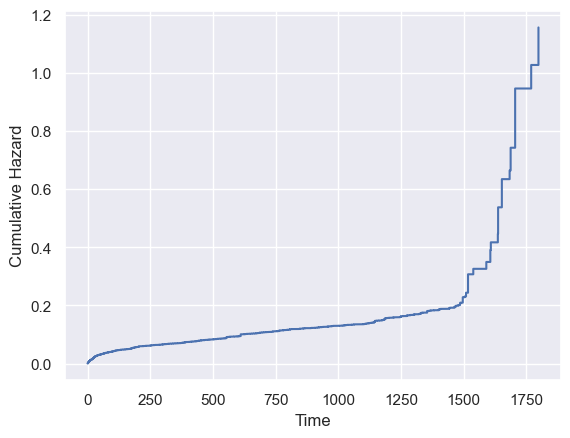

In [29]:
chf_funcs = model.predict_cumulative_hazard_function(X_train)
chf = chf_funcs[0]
plt.step(chf.x, chf(chf.x), where="post")
plt.ylabel("Cumulative Hazard")
plt.xlabel("Time")
plt.show()

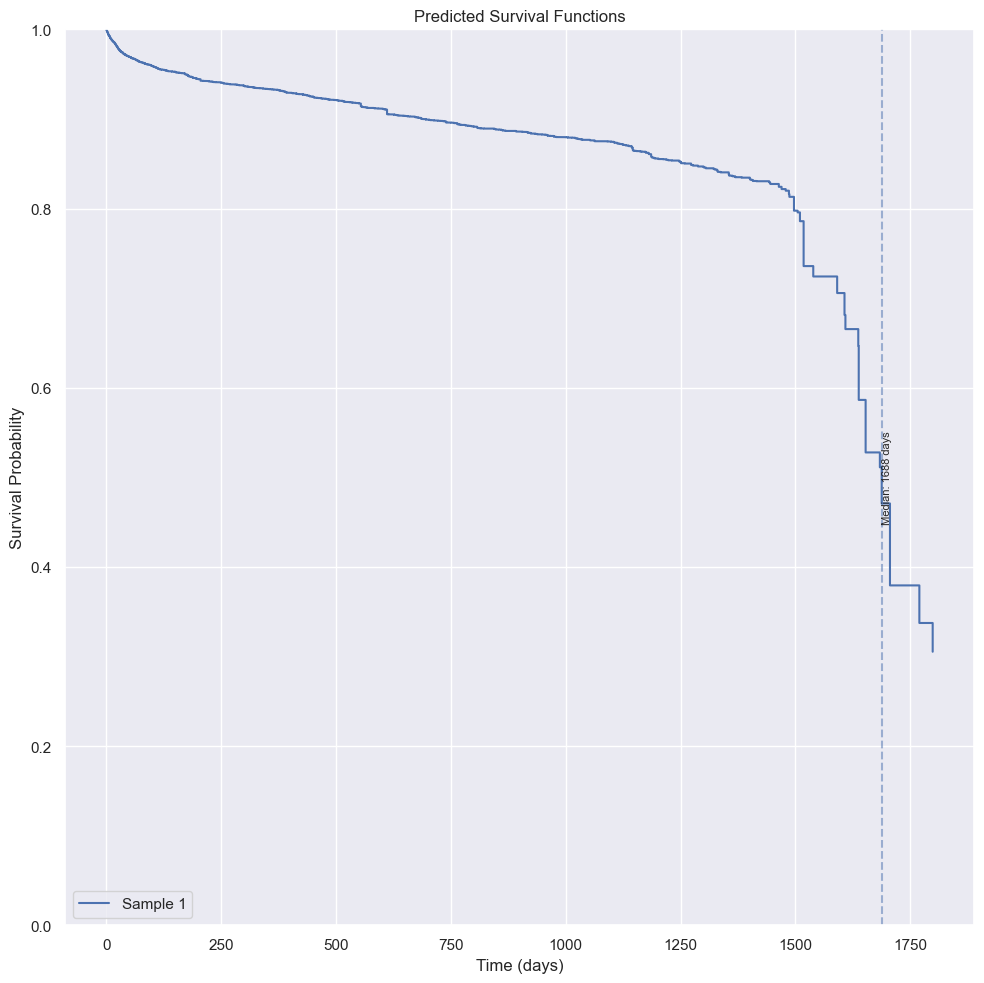

In [47]:
surv_funcs = model.predict_survival_function(X_train)

# Plot the survival functions
plt.figure(figsize=(10, 10))
for i, sf in enumerate(surv_funcs[:1]):  # Plot first 2 samples
    plt.step(sf.x, sf(sf.x), where="post", label=f"Sample {i+1}")

plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Functions")
plt.legend(loc="lower left")
plt.grid(True)
plt.ylim(0, 1)


# Add median survival time for each plotted sample
for i, sf in enumerate(surv_funcs[:1]):
    median_survival_time = sf.x[sf(sf.x) <= 0.5]
    if len(median_survival_time) > 0:
        median_survival_time = median_survival_time[0]
        plt.axvline(x=median_survival_time, color=f'C{i}', linestyle='--', alpha=0.5)
        plt.text(median_survival_time, 0.5, f'Median: {median_survival_time:.0f} days', 
                 rotation=90, verticalalignment='center', fontsize=8)
    else:
        plt.text(sf.x[-1], sf(sf.x)[-1], 'Median > max time', 
                 rotation=90, verticalalignment='bottom', fontsize=8)

plt.tight_layout()
plt.show()

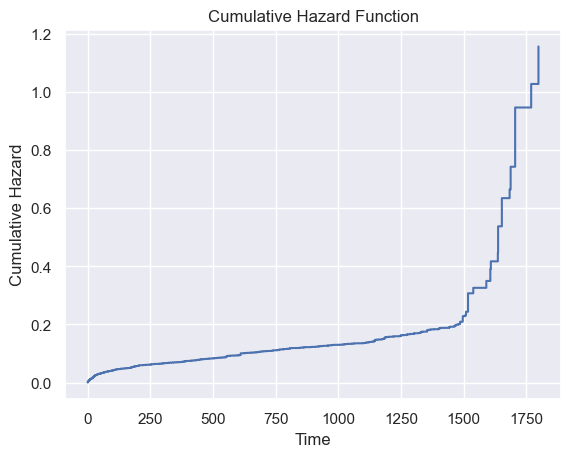

In [56]:
chf_funcs = model.predict_cumulative_hazard_function(X_train)
chf = chf_funcs[0]

# Plot the cumulative hazard
plt.step(chf.x, chf.y, where="post")
plt.ylabel("Cumulative Hazard")
plt.xlabel("Time")
plt.title("Cumulative Hazard Function")
plt.show()

In [54]:
# Randomly sample 20 values from chf.x and chf.y
random_indices = np.random.choice(len(chf.x), 20, replace=False)

# Print the random 20 values
for idx in random_indices:
    print(f"Time: {chf.x[idx]}, Cumulative Hazard: {chf.y[idx]}")

Time: 86.0, Cumulative Hazard: 0.057802671531873746
Time: 994.0, Cumulative Hazard: 0.16009360326247007
Time: 736.0, Cumulative Hazard: 0.13481779682766235
Time: 378.0, Cumulative Hazard: 0.09339160894426402
Time: 1290.0, Cumulative Hazard: 0.19213826332227327
Time: 1392.0, Cumulative Hazard: 0.19969283971025148
Time: 144.0, Cumulative Hazard: 0.07359099079169837
Time: 762.0, Cumulative Hazard: 0.13702584037417118
Time: 150.0, Cumulative Hazard: 0.07385684914717214
Time: 659.0, Cumulative Hazard: 0.12931015486097167
Time: 72.0, Cumulative Hazard: 0.05502915886250991
Time: 967.0, Cumulative Hazard: 0.15879840120355385
Time: 23.0, Cumulative Hazard: 0.029794963554440983
Time: 286.0, Cumulative Hazard: 0.08490490679748133
Time: 221.0, Cumulative Hazard: 0.07977104808207691
Time: 1405.0, Cumulative Hazard: 0.2016908609823797
Time: 1423.0, Cumulative Hazard: 0.2036847962684717
Time: 648.0, Cumulative Hazard: 0.12695890084097392
Time: 1004.0, Cumulative Hazard: 0.16073409626349328
Time: 958.

In [ ]:
# # Summary statistics
# for i, step_func in enumerate(surv_funcs):
#     print(f"Curve {i + 1}:")
#     print(f"  Final Survival Probability: {step_func.y[-1]:.4f}")
#     print(f"  Initial Survival Probability: {step_func.y[0]:.4f}")
#     print(f"  Median Survival Time: {step_func.x[len(step_func.y) // 2]}")
#     print()

In [51]:
# Assume `survival_curves` is your array of StepFunction objects
plt.figure(figsize=(10, 6))

for i, step_func in enumerate(surv_funcs):
    plt.step(step_func.x, step_func.y, where="post", label=f"Curve {i + 1}")

# Labeling and formatting the plot
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability Curves")
plt.legend()
plt.grid()
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 850x180066 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

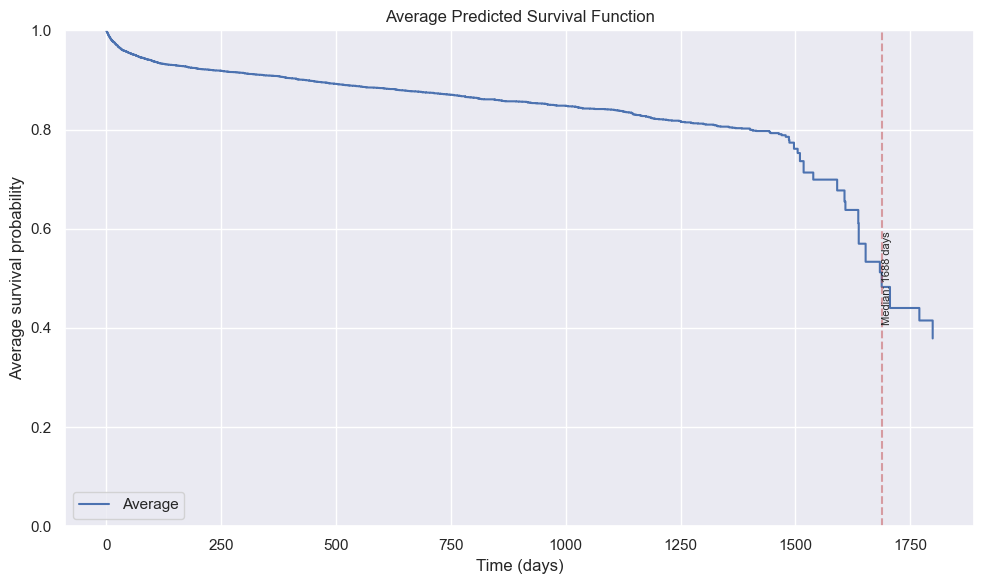

In [48]:
# Plot average survival function
plt.figure(figsize=(10, 6))
mean_survival = np.mean([sf(sf.x) for sf in surv_funcs], axis=0)
plt.step(surv_funcs[0].x, mean_survival, where="post", label="Average")

plt.xlabel("Time (days)")
plt.ylabel("Average survival probability")
plt.title("Average Predicted Survival Function")
plt.legend(loc="lower left")
plt.grid(True)
plt.ylim(0, 1)

# Add median survival time for average curve
median_survival_time = surv_funcs[0].x[mean_survival <= 0.5]
if len(median_survival_time) > 0:
    median_survival_time = median_survival_time[0]
    plt.axvline(x=median_survival_time, color='r', linestyle='--', alpha=0.5)
    plt.text(median_survival_time, 0.5, f'Median: {median_survival_time:.0f} days', 
             rotation=90, verticalalignment='center', fontsize=8)
else:
    plt.text(surv_funcs[0].x[-1], mean_survival[-1], 'Median > max time', 
             rotation=90, verticalalignment='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [34]:
model.unique_times_

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.706e+03, 1.770e+03,
       1.799e+03])

In [ ]:
# use best model for predictions
predictions = model.predict(X_train)

# calculate and print final concordance index
final_c_index = concordance_index_censored(y['event'], y['time'], predictions)[0]
print("\nFinal concordance index:", final_c_index)

# Permutation importance
print("\nCalculating permutation importance...")
perm_importance = permutation_importance(model, X_train y_train, n_repeats=10, random_state=RANDOM_STATE)

# sort features by importance
feature_names = X_train.columns
sorted_idx = perm_importance.importances_mean.argsort()

# display features
print(f"\nTotal number of features: {len(feature_names)}")

# Determine the number of features to print (either 10 or the total number of features, whichever is smaller)
num_features_to_print = min(20, len(feature_names))

print(f"\nTop {num_features_to_print} most important features:")
for i in range(1, num_features_to_print + 1):
    idx = sorted_idx[-i]
    print(f"{feature_names[idx]}: {perm_importance.importances_mean[idx]:.4f} ± {perm_importance.importances_std[idx]:.4f}")

In [23]:
from sklearn.inspection import permutation_importance

# Get permutation importance for the RandomSurvivalForest model
results = permutation_importance(rsf, X_train, y_train, n_repeats=10,  n_jobs=-1, random_state=RANDOM_STATE)

In [ ]:
# Get importance scores
importances = results.importances_mean

# Assuming you have feature names in X_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importances_df)

In [103]:
# finding the indices where 'event' is True
true_indices = np.where((y_val['event'] == 1) & (y_val['time'] < 5))

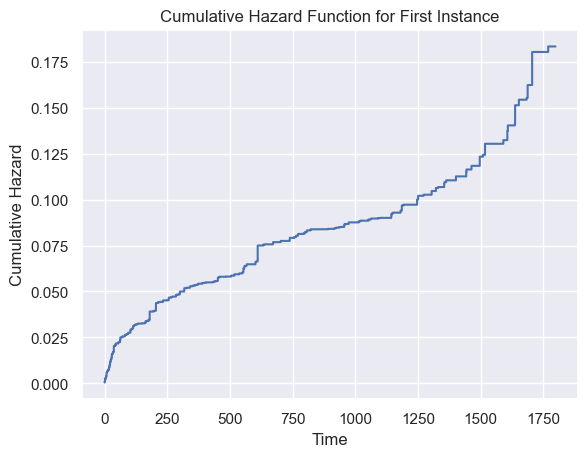

In [71]:
# Predict cumulative hazard functions for each instance in X_train
cumulative_hazards = rsf.predict_cumulative_hazard_function(X_train)

# Example: Plot cumulative hazard function for the first instance
time_points = cumulative_hazards[0].x   # Time points for cumulative hazard
hazard_values = cumulative_hazards[0].y # Cumulative hazard values

plt.step(time_points, hazard_values, where="post")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.title("Cumulative Hazard Function for First Instance")
plt.show()

In [102]:
df_dict[df_dict.featureName.str.contains('TransplantStatus_CAN')]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
213,TransplantStatus_CAN,"Boolean Most Recent Patient Status (based on composite death date) (1=Dead, 0=Alive)",TRR/TRF-CALCULATED,PATIENT STATUS,Nominal - NUM,Boolean Most Recent Patient Status (based on composite death date),Unknown,Label - {'PSTATUS': 'TransplantStatus_CAN'}


In [113]:
# finding the indices where 'event' is 1
true_indices = np.where((y_val['event'] == 1) & (y_val['time'] < 1))

true_indices

(array([ 490,  707, 1180, 1470, 1609]),)

In [115]:
# predict survival functions for the few instances
pred_surv = rsf.predict_survival_function(X_val.iloc[true_indices])

In [116]:
y_val[true_indices]

array([( True, 0.), ( True, 0.), ( True, 0.), ( True, 0.), ( True, 0.)],
      dtype=[('event', '?'), ('time', '<f8')])

In [117]:
# Predict survival functions for the first few instances
pred_surv = rsf.predict_survival_function(X_val.iloc[true_indices])

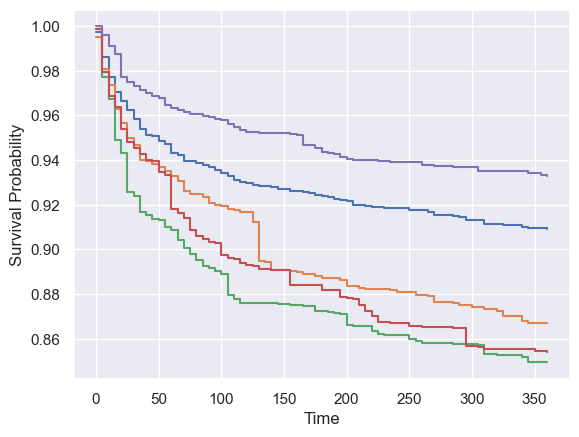

In [118]:
time_points = np.arange(0, 365, 5)
for fn in pred_surv:
    plt.step(time_points, fn(time_points), where="post")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

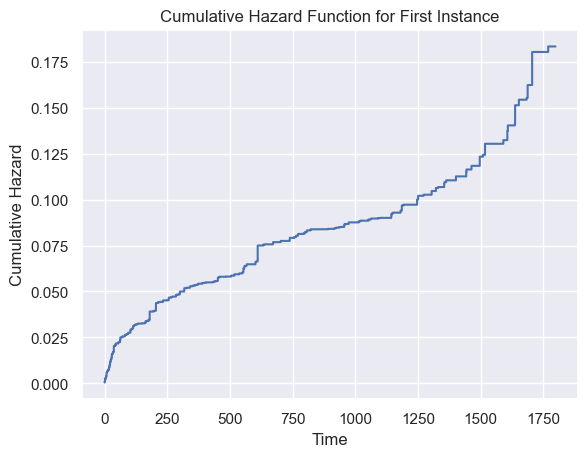

In [121]:
# predict cumulative hazard functions for each instance in X_train
cumulative_hazards = rsf.predict_cumulative_hazard_function(X_train)

# plot cumulative hazard function for the first instance
time_points = cumulative_hazards[0].x   # time points for cumulative hazard
hazard_values = cumulative_hazards[0].y # cumulative hazard values

plt.step(time_points, hazard_values, where="post")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.title("Cumulative Hazard Function for First Instance")
plt.show()

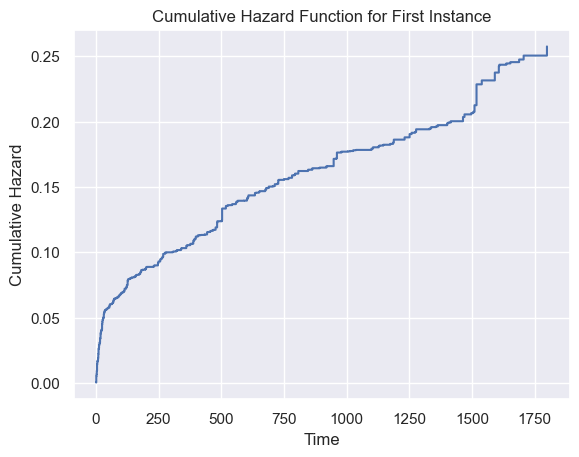

In [122]:
# predict cumulative hazard functions for each instance in X_val
cumulative_hazards = rsf.predict_cumulative_hazard_function(X_val)

# plot cumulative hazard function for the first instance
time_points = cumulative_hazards[0].x   # time points for cumulative hazard
hazard_values = cumulative_hazards[0].y # cumulative hazard values

plt.step(time_points, hazard_values, where="post")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.title("Cumulative Hazard Function for First Instance")
plt.show()

In [129]:
rsf.feature_names_in_

array(['PreviousTransplantNumber_CAN', 'EducationLevel_CAN',
       'IntropesIV_CAN', 'FunctionalStatus_CAN', 'TotalDayWaitList_CAN',
       'Ventilator_CAN', 'PreTransplantMedicalCondition_CAN',
       'PreviousTransplantSameOrgan_CAN',
       'PreviousTransplantAnyOrgan_CAN', 'MismatchLevel_LOCUS',
       'MismatchLevel_B_LOCUS', 'MismatchLevel_DR_LOCUS',
       'MismatchLevel_HLA', 'BloodInfectionSource_DON',
       'BloodUreaNitrogenLevel_DON', 'PulmonaryInfection_DON',
       'UrineInfection_DON', 'DiabetesHistory_DON', 'ResultHIV_NAT_DON',
       'BloodGroupMatchLevel', 'IschemicTimeHours_DON',
       'DistanceFrom_DON_HospitaltoTXCenter',
       'LV_EjectionFractionPercent_DON', 'KidneyAllocation_DON',
       'PCO2_DON', 'BloodPH_DON', 'Hematocrit_DON', 'WeightKg_DON',
       'WeightKg_CAN', 'PF_Ratio_DON', 'Age_Difference', 'BMI_Difference',
       'Creatinine_Difference', 'HeightCm_Difference',
       'TotalBilirubin_Difference', 'WeightKg_Difference',
       'Level_SGOT_Diffe

In [133]:
rsf.score(X_train, y_train)

0.9805321957618633

In [134]:
rsf.score(X_val, y_val)

0.6234363406452152

In [135]:
rsf.score(X_test, y_test)

0.599274445690828

In [154]:
from sksurv.metrics import concordance_index_censored

In [ ]:
def cross_validate_rsf(X, y, model, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    c_indices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        c_index = concordance_index_censored(y_test['event'], y_test['Time'], y_pred)
        c_indices.append(c_index[0])
    
    return np.mean(c_indices), np.std(c_indices)

In [151]:
# create a Random Survival Forest model
rsf1 = RandomSurvivalForest(n_estimators=100, min_samples_split=20, max_depth=5,  n_jobs= -1, random_state=RANDOM_STATE)

rsf1.fit(X_train, y_train)

RandomSurvivalForest(max_depth=5, min_samples_split=20, n_jobs=-1,
                     random_state=1776)

In [152]:
rsf1.score(X_train, y_train)

0.75269798733119

In [153]:
rsf1.score(X_val, y_val)

0.6151778156318908

In [160]:
y_val[true_indices]

array([( True, 0.), ( True, 0.), ( True, 0.), ( True, 0.), ( True, 0.)],
      dtype=[('event', '?'), ('time', '<f8')])

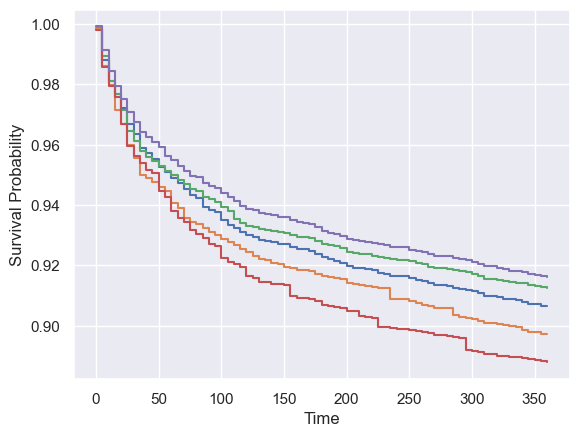

In [157]:
# predict survival functions for the few instances
pred_surv = rsf1.predict_survival_function(X_val.iloc[true_indices])

time_points = np.arange(0, 365, 5)
for fn in pred_surv:
    plt.step(time_points, fn(time_points), where="post")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

#### Scale DataSet

In [ ]:
# import Standard Sclaer library
from sklearn.preprocessing import MinMaxScaler

# initialize scaler
scaler = MinMaxScaler()

# fit train
MinMaxScale = scaler.fit(X_train)

# transform train/val/test
X_train_scale = MinMaxScale.transform(X_train)
X_val_scale = MinMaxScale.transform(X_val)
X_test_scale = MinMaxScale.transform(X_test)

# convert to DataFrame
X_train_scale_df = pd.DataFrame(X_train_scale, columns=X.columns.to_list())
X_val_scale_df = pd.DataFrame(X_val_scale, columns=X.columns.to_list())
X_test_scale_df = pd.DataFrame(X_test_scale, columns=X.columns.to_list())

### Feature Selection

In [ ]:
# import libraries
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

# remove constant features
constanFilter = VarianceThreshold(threshold=0)  # removes features with zero variance
X_train_scaled = constanFilter.fit_transform(X_train_scale_df)

# update feature names after removing constant features
remaining_feature_names = X_train_scale_df.columns[constanFilter.get_support(indices=True)]

# Step 3: Apply SelectKBest with F-classif
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X_train_scaled, y_train)

# Update feature names to reflect remaining, selected features
selected = [remaining_feature_names[i] for i in selector.get_support(indices=True)]

# Step 4: Create a DataFrame with selected features and their F-scores
feature_scores = selector.scores_
feature_scores_df = pd.DataFrame({
    'Feature': remaining_feature_names,
    'F-Score': feature_scores
}).sort_values(by='F-Score', ascending=False)

# display top 20 features by F-Score
feature_scores_df[feature_scores_df['Feature'].isin(selected)].head(20)

##### F-score Values
The F-score is a measure of statistical significance, representing the variance between groups relative to the variance within groups. Higher scores typically indicate features that can better differentiate between classes in a classification task or explain more variance in a regression task.

- Choosing Feature Thresholds
    - Above 20: Often highly relevant features.
    - 10–20: Moderately important but may still add predictive power.
    - Below 10: These may add noise or are less informa

In [ ]:
import re

# Get features
allFeatures = feature_scores_df[feature_scores_df['Feature'].isin(selected)].sort_values(by='F-Score', ascending=False)
features = allFeatures.Feature[(allFeatures.Feature.str.contains('_U')) & (allFeatures['F-Score'] >= 8)]
# features = allFeatures.Feature[(allFeatures.Feature.str.contains('_U'))]

# extract the feature name up to (but not including) '_U'
newFeatures = [re.search(r'^(.*?)_U', feature).group(1) if '_U' in feature else feature for feature in features]

print(newFeatures)

In [ ]:
# select features with F-Score >= 10
selectedFeatures = allFeatures['Feature'][allFeatures['F-Score'] >= 10]

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [ ]:
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(2, 20, num=3, dtype=np.intc))
# The number of trees in the fores
n_estimators = list(np.linspace(25, 500, num=4, dtype=np.intc))
# maximum number of levels in tree
max_depth = list(np.linspace(2, 11, num=3, dtype=np.intc))
max_depth.append(None)
# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
n_estimators=n_estimators,
criterion = ['gini', 'entropy', 'log_loss'],
# class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'],
class_weight = ['balanced'],
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'n_jobs': -1,'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

In [ ]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - balanced_accuracy - F-Score >=10'
Model = 'rfc_one_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_one_fit = stratified_grid(model, parameters, X_train_scale_df[selectedFeatures], y_train, nSplit=10, score = 'balanced_accuracy')

# best model
model = rfc_one_fit.best_estimator_

In [ ]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_scale_df[selectedFeatures], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# copy first metrics dataframe
df_classfication = df_metrics.copy()

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_scale_df[selectedFeatures], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# plot
plotFeatureImportance(model, X_train_scale_df[selectedFeatures],figsize=(10,6))

### Logistic Regression

In [ ]:
# define the hyperparameter grid to search
parameters = dict(
C = list(np.round(np.linspace(0.01, 5, 20),2)),
class_weight = ['balanced']
)

# Base Model
lrc_param = {'max_iter':10000, 'random_state': RANDOM_STATE}

# instantiate LogisticRegression Classifier
model = LogisticRegression(**lrc_param)

In [ ]:
# initialize variables
Algorithm = 'LogisticRegression'
Desc = 'LogisticRegression - Grid Search - balanced_accuracy - F-Score >=10'
Model = 'lrc_one_fit'

# CV with grid search for Hyper-Parameter tuning
lrc_onel_fit = stratified_grid(model, parameters, X_train_scale_df[selectedFeatures], y_train, nSplit=10, score = 'balanced_accuracy')

# best model
model = lrc_onel_fit.best_estimator_

In [ ]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_scale_df[selectedFeatures], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_scale_df[selectedFeatures], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication